In [1]:
#!pip show tensorflow_datasets
!pip3 install emnist
!pip3 install tensorflow_datasets
!pip3 install opencv_python
!pip3 install matplotlib
!pip3 install chardet
!pip3 install pandas

In [2]:
# import emnist
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import sklearn
import random
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
import cv2
from tensorflow.keras.layers import Input, Lambda, Conv2D,Conv2DTranspose, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline
# tf.debugging.set_log_device_placement(False)

In [3]:
print(tf.config.list_physical_devices('GPU'))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
True


In [4]:
(ds_train, ds_test), info = tfds.load('omniglot', split=['train', 'test'], with_info=True)

In [5]:
df_train = tfds.as_dataframe(ds_train, info)
df_test  = tfds.as_dataframe(ds_test, info)

In [6]:
train_images = np.stack(df_train['image'])
train_images.shape

(19280, 105, 105, 3)

In [7]:
df_train.columns

Index(['alphabet', 'alphabet_char_id', 'image', 'label'], dtype='object')

In [8]:
len(df_train['label'].unique())

964

In [9]:
# Hyperparameters

shots = 1
num_boost = 2
# train_shots = 5
num_classes = 20
img_size = 56
batch_size = 32
num_mini_iterations = 1000

In [10]:
''' Data handling general functions '''

def separate_fewshot(test_images, test_labels, n=1, shuffle_clas=False):
    oneshot_data = []
    classify_data = []
    for label in np.unique(test_labels):
        for num in np.random.choice(np.where(test_labels == label)[0], n, False):
            oneshot_data.append(num)
    temp = set(oneshot_data)
    for i in range(len(test_labels)):
        if not i in temp: classify_data.append(i)
    oneshot_images = test_images[oneshot_data]
    oneshot_labels = test_labels[oneshot_data]
    if shuffle_clas:
        np.random.shuffle(classify_data)
    classify_images = test_images[classify_data]
    classify_labels = test_labels[classify_data]
    return oneshot_images, oneshot_labels, classify_images, classify_labels

In [11]:
def resize_images(images, size, to_grayscale = True):
    resized_images = []
    for img in images:
        resized_image = cv2.resize(img, (size, size))
        if to_grayscale:
            resized_image= cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        resized_images.append(resized_image)
    return np.array(resized_images)

In [12]:
def parse_omniglot_dataframe(df, img_size = 56, reshape=True):
    images = resize_images(df['image'], img_size)
    if reshape:
        images = images.reshape(-1, img_size * img_size)
        images = images.astype("float") / 255.0
    else:
        image = images.reshape(-1, img_size, img_size)
        images = images.astype("float") / 255.0
        images = images[..., np.newaxis]
    labels = df['label'].to_numpy()
    data = {}
    for label in np.unique(labels):
        data[label] = images[np.where(labels == label)]
    return (data, labels)

In [13]:
def get_batch(data, labels, num_iterations=10, num_classes=num_classes, shots=shots, num_support=train_shots, img_size=img_size):
    unique_labels = np.unique(labels)
    num_labels = unique_labels.shape[0]
    np.random.shuffle(unique_labels)
    
    x = np.zeros(shape=(num_classes * shots, img_size, img_size, 1))
    y = np.zeros(shape=(num_classes * num_support, img_size, img_size,1))
    x_l, y_l = np.zeros(num_classes * shots), np.zeros(num_classes * num_support)
    
    size = num_classes * num_classes * shots * num_support
    num_iterations = min(num_iterations, (num_labels + num_classes - 1) // num_classes)
    
    pairs = [[None for _ in range(size * num_iterations)], [None for _ in range(size * num_iterations)]]
    #labels = [[None for _ in range(size * num_iterations)], [None for _ in range(size * num_iterations)]]
    target = np.zeros(size * num_iterations)
    
    cur = 0
    x_label = [None for _ in range(num_iterations * num_classes)]
    for t in range(0, num_iterations * num_classes, num_classes):
        classes = unique_labels[t: t + num_classes]
        #classes = np.random.choice(labels, n_classes, False)        
        for i, c in enumerate(classes):
            x_label[t + i] = c
            ind = np.random.choice(np.arange(data[c].shape[0]), shots + num_support, False)
            x_ind = ind[:shots]
            #print(x_ind.shape, data[c][x_ind].shape, x[i * shots: (i+1) * shots])
            x[i * shots: (i+1) * shots, :][0] = data[c][x_ind]
            x_l[i * shots: (i+1) * shots] = c

            y_ind = ind[shots:]
            y[i * num_support: (i+1) * num_support, :] = data[c][y_ind]
            y_l[i * num_support: (i+1) * num_support] = c
            
        for i, xx in enumerate(x):
            if x_l[i] not in classes:
                continue
            for j, yy in enumerate(y):
                if y_l[j] not in classes:
                    continue
                pairs[0][cur] = xx
                pairs[1][cur] = yy
                target[cur] = ((x_l[i] == y_l[j]) and (x_l[i] != -1))
                cur += 1
    pairs[0] = pairs[0][:cur]
    pairs[1] = pairs[1][:cur]
    target = target[:cur]
    return pairs, target, np.array(x_label)

In [14]:
data, lbl = parse_omniglot_dataframe(df_test, reshape=False)
data[lbl[0]].shape
get_batch(data, lbl)[2].shape

(200,)

In [15]:
def get_siamese_net_and_encoder(input_shape, code_size = 0):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    encoder = Sequential()
    encoder.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu', kernel_regularizer='l2'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=2))
    encoder.add(Dropout(0.25))
    
    encoder.add(Conv2D(128, (3, 3), kernel_regularizer='l2'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=2))
    encoder.add(Dropout(0.25))
    
#     encoder.add(Conv2D(128, (2, 2), kernel_regularizer='l2'))
#     encoder.add(BatchNormalization())
#     encoder.add(Activation('relu'))
#     encoder.add(MaxPooling2D(pool_size=2))
#     encoder.add(Dropout(0.25))
    #encoder.add(Conv2D(256, (4, 4), kernel_regularizer='l2'))
    
    encoder.add(Flatten())
    
    encoder.add(Dense(1024, activation='sigmoid', kernel_regularizer='l2'))
    
    left_emb = encoder(left_input)
    right_emb = encoder(right_input)
    
    L1_Layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_Dist = L1_Layer([left_emb,right_emb])
    OP = Dense(1, activation='sigmoid', kernel_regularizer='l2')(L1_Dist)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=OP)
    
    return siamese_net, encoder


In [16]:
siamese_net, encoder = get_siamese_net_and_encoder((img_size, img_size, 1))

siamese_net.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56, 56, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 56, 56, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 1024)         3420288     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1024)         0           ['sequential[0][0]',         

In [17]:
def get_random_images(images):
    ind = np.arange(images.shape[0])
    ind = np.random.choice(ind, 1)[0]
    return images[ind]

def get_train_data(size, train_data, train_labels, img_size):
    targets = np.zeros((size,))
    targets[2 * size // 3:] = 1
    pairs = [np.zeros((size, img_size, img_size, 1)) for _ in range(2)]
    labels = np.unique(train_labels)
    for i in range(size):
        class1 = np.random.choice(labels, 1)[0]
        class2 = class1
        if i < 2 * size // 3:
            while class2 == class1:
                class2 = np.random.choice(labels, 1)[0]
        pairs[0][i] = get_random_images(train_data[class1])
        pairs[1][i] = get_random_images(train_data[class2])
    return pairs, targets

def visualize_siamese(siamese_net, train_data, label1 = 1, label2=2):
    x = train_data[label1][:1]
    y = train_data[label2][1:2]
    d = siamese_net.predict([x, y], verbose=0)
    fig, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].axis("off")
    axis[1].axis("off")
    fig.suptitle(f"Output {d[0][0]}")
    axis[0].imshow(x[0], cmap='gray')
    axis[1].imshow(y[0], cmap='gray')
    plt.show()

In [18]:
train_data, train_labels = parse_omniglot_dataframe(df_train, img_size=img_size, reshape=False)
checkpoint_callback = ModelCheckpoint("./new_siamese_model_w_encoder", monitor='loss', verbose=1, save_best_only=True, mode='auto', period=100)
def train_one_shot():
    leftover_x0 = np.array([])
    leftover_x1 = np.array([])
    for i in range(1, num_mini_iterations + 1):
        print(f"Epoch {i}:")
        #x, y, _ = get_batch(train_data, train_labels, shots=shots, num_classes=num_classes, num_support=train_shots, img_size=img_size)
        x, y = get_train_data(2048, train_data, train_labels, img_size=img_size)
        loss = siamese_net.fit(x, y, batch_size=batch_size, callbacks=[checkpoint_callback])
        size = 2 * 2048// 3 
        t = siamese_net.predict(x, verbose=0).reshape(-1)
        ind = np.where((2 * t - 1) * (2 * y - 1) < .3)[0]
        for _ in range(num_boost):
            np.random.shuffle(ind)
            leftover_x0 = np.tile(x[0][ind], (1,1,1,1))
            leftover_x1 = np.tile(x[1][ind], (1,1,1,1))
            leftover_y = np.tile(y[ind], 1)
        
            #print(leftover_x0.shape, leftover_x1.shape)
            siamese_net.fit([leftover_x0, leftover_x1], leftover_y, batch_size=batch_size)
        
        #if i % evaluateEvery == 0:
        #    print('Iteration', i, '- Loss:',loss[0],'- Acc:', round(loss[1], 2))
train_one_shot()

Epoch 1:
42/42 [==============================] - 0s 6ms/step - loss: 0.3425 - accuracy: 0.9992
Epoch 2:
18/18 [==============================] - 0s 6ms/step - loss: 0.4164 - accuracy: 0.9930
Epoch 3:
19/19 [==============================] - 0s 6ms/step - loss: 0.3952 - accuracy: 0.9866
Epoch 4:
16/16 [==============================] - 0s 7ms/step - loss: 0.7628 - accuracy: 0.8552
Epoch 5:
20/20 [==============================] - 0s 7ms/step - loss: 0.3105 - accuracy: 0.9952
Epoch 6:
18/18 [==============================] - 0s 6ms/step - loss: 0.5773 - accuracy: 0.9358
Epoch 7:
18/18 [==============================] - 0s 6ms/step - loss: 0.4360 - accuracy: 0.9745
Epoch 8:
15/15 [==============================] - 0s 6ms/step - loss: 0.7579 - accuracy: 0.8252
Epoch 9:
17/17 [==============================] - 0s 7ms/step - loss: 0.4395 - accuracy: 0.9776
Epoch 10:
15/15 [==============================] - 0s 6ms/step - loss: 0.7715 - accuracy: 0.7296
Epoch 11:
17/17 [======================

9/9 [==============================] - 0s 7ms/step - loss: 1.0476 - accuracy: 0.6212
Epoch 62:
8/8 [==============================] - 0s 6ms/step - loss: 0.8448 - accuracy: 0.8047
Epoch 63:
11/11 [==============================] - 0s 6ms/step - loss: 0.8599 - accuracy: 0.7143
Epoch 64:
14/14 [==============================] - 0s 6ms/step - loss: 0.8437 - accuracy: 0.7666
Epoch 65:
11/11 [==============================] - 0s 6ms/step - loss: 0.9024 - accuracy: 0.7508
Epoch 66:
10/10 [==============================] - 0s 6ms/step - loss: 0.9616 - accuracy: 0.6946
Epoch 67:
9/9 [==============================] - 0s 6ms/step - loss: 1.0037 - accuracy: 0.6800
Epoch 68:
8/8 [==============================] - 0s 6ms/step - loss: 0.9428 - accuracy: 0.6719
Epoch 69:
14/14 [==============================] - 0s 6ms/step - loss: 0.7270 - accuracy: 0.8307
Epoch 70:
9/9 [==============================] - 0s 7ms/step - loss: 0.8997 - accuracy: 0.7343
Epoch 71:
13/13 [==============================] -

INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


12/12 [==============================] - 0s 7ms/step - loss: 0.9510 - accuracy: 0.6919
Epoch 101:
15/15 [==============================] - 0s 6ms/step - loss: 0.8842 - accuracy: 0.7201
Epoch 102:
10/10 [==============================] - 0s 6ms/step - loss: 0.9384 - accuracy: 0.6561
Epoch 103:
10/10 [==============================] - 0s 6ms/step - loss: 0.9581 - accuracy: 0.6745
Epoch 104:
18/18 [==============================] - 0s 6ms/step - loss: 1.1356 - accuracy: 0.9176
Epoch 105:
10/10 [==============================] - 0s 6ms/step - loss: 0.8585 - accuracy: 0.7860
Epoch 106:
9/9 [==============================] - 0s 6ms/step - loss: 0.9913 - accuracy: 0.6795
Epoch 107:
11/11 [==============================] - 0s 7ms/step - loss: 0.7340 - accuracy: 0.8430
Epoch 108:
9/9 [==============================] - 0s 6ms/step - loss: 0.9052 - accuracy: 0.7061
Epoch 109:
8/8 [==============================] - 0s 6ms/step - loss: 0.9290 - accuracy: 0.6609
Epoch 110:
9/9 [=====================

10/10 [==============================] - 0s 6ms/step - loss: 0.9494 - accuracy: 0.7629
Epoch 131:
9/9 [==============================] - 0s 6ms/step - loss: 0.8598 - accuracy: 0.7396
Epoch 132:
11/11 [==============================] - 0s 6ms/step - loss: 0.7855 - accuracy: 0.7713
Epoch 133:
9/9 [==============================] - 0s 6ms/step - loss: 0.7624 - accuracy: 0.8456
Epoch 134:
25/25 [==============================] - 0s 6ms/step - loss: 0.5152 - accuracy: 0.9339
Epoch 135:
10/10 [==============================] - 0s 6ms/step - loss: 0.9344 - accuracy: 0.6875
Epoch 136:
14/14 [==============================] - 0s 6ms/step - loss: 0.5558 - accuracy: 0.9064
Epoch 137:
8/8 [==============================] - 0s 6ms/step - loss: 1.0795 - accuracy: 0.5903
Epoch 138:
12/12 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.8757
Epoch 139:
18/18 [==============================] - 0s 6ms/step - loss: 0.5433 - accuracy: 0.9089
Epoch 140:
7/7 [=====================

18/18 [==============================] - 0s 6ms/step - loss: 0.3845 - accuracy: 0.9615
Epoch 192:
9/9 [==============================] - 0s 6ms/step - loss: 0.8238 - accuracy: 0.7814
Epoch 193:
10/10 [==============================] - 0s 6ms/step - loss: 0.5882 - accuracy: 0.8987
Epoch 194:
13/13 [==============================] - 0s 6ms/step - loss: 0.8358 - accuracy: 0.7964
Epoch 195:
10/10 [==============================] - 0s 6ms/step - loss: 0.6835 - accuracy: 0.8097
Epoch 196:
8/8 [==============================] - 0s 6ms/step - loss: 0.8791 - accuracy: 0.6966
Epoch 197:
16/16 [==============================] - 0s 6ms/step - loss: 0.4491 - accuracy: 0.9427
Epoch 198:
10/10 [==============================] - 0s 7ms/step - loss: 0.6465 - accuracy: 0.8486
Epoch 199:
10/10 [==============================] - 0s 7ms/step - loss: 0.6196 - accuracy: 0.9016
Epoch 200:
63/64 [============================>.] - ETA: 0s - loss: 0.6287 - accuracy: 0.8477
Epoch 1: loss improved from 0.70154 to 

INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


7/7 [==============================] - 0s 6ms/step - loss: 0.9086 - accuracy: 0.6524
Epoch 201:
6/6 [==============================] - 0s 7ms/step - loss: 0.9473 - accuracy: 0.6073
Epoch 202:
7/7 [==============================] - 0s 6ms/step - loss: 0.9125 - accuracy: 0.6386
Epoch 203:
11/11 [==============================] - 0s 6ms/step - loss: 0.7041 - accuracy: 0.8464
Epoch 204:
8/8 [==============================] - 0s 6ms/step - loss: 0.8807 - accuracy: 0.7269
Epoch 205:
16/16 [==============================] - 0s 6ms/step - loss: 0.4196 - accuracy: 0.9652
Epoch 206:
9/9 [==============================] - 0s 6ms/step - loss: 0.8268 - accuracy: 0.7663
Epoch 207:
8/8 [==============================] - 0s 6ms/step - loss: 0.8398 - accuracy: 0.7076
Epoch 208:
9/9 [==============================] - 0s 6ms/step - loss: 0.8435 - accuracy: 0.7353
Epoch 209:
8/8 [==============================] - 0s 6ms/step - loss: 0.8388 - accuracy: 0.7033
Epoch 210:
21/21 [=============================

7/7 [==============================] - 0s 7ms/step - loss: 0.9096 - accuracy: 0.6393
Epoch 261:
10/10 [==============================] - 0s 6ms/step - loss: 0.5890 - accuracy: 0.8885
Epoch 262:
9/9 [==============================] - 0s 6ms/step - loss: 0.7668 - accuracy: 0.7625
Epoch 263:
10/10 [==============================] - 0s 6ms/step - loss: 0.6129 - accuracy: 0.8658
Epoch 264:
17/17 [==============================] - 0s 6ms/step - loss: 0.3200 - accuracy: 0.9786
Epoch 265:
7/7 [==============================] - 0s 6ms/step - loss: 1.0159 - accuracy: 0.5350
Epoch 266:
9/9 [==============================] - 0s 7ms/step - loss: 0.7863 - accuracy: 0.8014
Epoch 267:
13/13 [==============================] - 0s 7ms/step - loss: 0.4948 - accuracy: 0.9122
Epoch 268:
12/12 [==============================] - 0s 6ms/step - loss: 0.5082 - accuracy: 0.9183
Epoch 269:
13/13 [==============================] - 0s 6ms/step - loss: 0.5410 - accuracy: 0.9460
Epoch 270:
8/8 [=======================

16/16 [==============================] - 0s 6ms/step - loss: 0.4605 - accuracy: 0.9324
Epoch 292:
8/8 [==============================] - 0s 6ms/step - loss: 0.7148 - accuracy: 0.7953
Epoch 293:
8/8 [==============================] - 0s 6ms/step - loss: 1.0315 - accuracy: 0.4934
Epoch 294:
9/9 [==============================] - 0s 6ms/step - loss: 0.7183 - accuracy: 0.7943
Epoch 295:
8/8 [==============================] - 0s 6ms/step - loss: 0.9264 - accuracy: 0.6504
Epoch 296:
7/7 [==============================] - 0s 6ms/step - loss: 1.0231 - accuracy: 0.5174
Epoch 297:
12/12 [==============================] - 0s 6ms/step - loss: 0.5575 - accuracy: 0.8946
Epoch 298:
13/13 [==============================] - 0s 6ms/step - loss: 0.5250 - accuracy: 0.9024
Epoch 299:
8/8 [==============================] - 0s 6ms/step - loss: 0.7296 - accuracy: 0.8033
Epoch 300:
64/64 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.8550
Epoch 1: loss improved from 0.62718 to 0.60654,

INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


8/8 [==============================] - 0s 7ms/step - loss: 0.8044 - accuracy: 0.6980
Epoch 301:
9/9 [==============================] - 0s 9ms/step - loss: 0.8482 - accuracy: 0.6988
Epoch 302:
8/8 [==============================] - 0s 6ms/step - loss: 0.8659 - accuracy: 0.7126
Epoch 303:
8/8 [==============================] - 0s 6ms/step - loss: 0.7999 - accuracy: 0.7595
Epoch 304:
8/8 [==============================] - 0s 7ms/step - loss: 0.7439 - accuracy: 0.7047
Epoch 305:
12/12 [==============================] - 0s 6ms/step - loss: 0.4993 - accuracy: 0.9211
Epoch 306:
23/23 [==============================] - 0s 6ms/step - loss: 0.3034 - accuracy: 0.9716
Epoch 307:
8/8 [==============================] - 0s 7ms/step - loss: 0.7911 - accuracy: 0.7628
Epoch 308:
6/6 [==============================] - 0s 6ms/step - loss: 0.9727 - accuracy: 0.5385
Epoch 309:
13/13 [==============================] - 0s 6ms/step - loss: 0.4865 - accuracy: 0.9293
Epoch 310:
15/15 [===========================

8/8 [==============================] - 0s 6ms/step - loss: 0.7521 - accuracy: 0.7686
Epoch 361:
13/13 [==============================] - 0s 6ms/step - loss: 0.4921 - accuracy: 0.9348
Epoch 362:
8/8 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.8383
Epoch 363:
9/9 [==============================] - 0s 6ms/step - loss: 0.5137 - accuracy: 0.9201
Epoch 364:
10/10 [==============================] - 0s 6ms/step - loss: 0.5580 - accuracy: 0.8697
Epoch 365:
7/7 [==============================] - 0s 6ms/step - loss: 0.8293 - accuracy: 0.7000
Epoch 366:
7/7 [==============================] - 0s 6ms/step - loss: 0.8210 - accuracy: 0.7169
Epoch 367:
11/11 [==============================] - 0s 6ms/step - loss: 0.5289 - accuracy: 0.9129
Epoch 368:
6/6 [==============================] - 0s 6ms/step - loss: 0.8928 - accuracy: 0.5542
Epoch 369:
11/11 [==============================] - 0s 6ms/step - loss: 0.5779 - accuracy: 0.9116
Epoch 370:
28/28 [=========================

INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


10/10 [==============================] - 0s 6ms/step - loss: 0.5170 - accuracy: 0.9286
Epoch 401:
11/11 [==============================] - 0s 6ms/step - loss: 0.4937 - accuracy: 0.9339
Epoch 402:
7/7 [==============================] - 0s 6ms/step - loss: 0.6481 - accuracy: 0.8419
Epoch 403:
13/13 [==============================] - 0s 6ms/step - loss: 0.4087 - accuracy: 0.9690
Epoch 404:
10/10 [==============================] - 0s 6ms/step - loss: 0.5253 - accuracy: 0.9043
Epoch 405:
8/8 [==============================] - 0s 6ms/step - loss: 0.6182 - accuracy: 0.8667
Epoch 406:
8/8 [==============================] - 0s 7ms/step - loss: 0.6945 - accuracy: 0.8095
Epoch 407:
15/15 [==============================] - 0s 6ms/step - loss: 0.3583 - accuracy: 0.9706
Epoch 408:
12/12 [==============================] - 0s 6ms/step - loss: 0.4647 - accuracy: 0.9188
Epoch 409:
8/8 [==============================] - 0s 7ms/step - loss: 0.6495 - accuracy: 0.7984
Epoch 410:
23/23 [=====================

9/9 [==============================] - 0s 6ms/step - loss: 0.6350 - accuracy: 0.8597
Epoch 461:
6/6 [==============================] - 0s 6ms/step - loss: 0.9682 - accuracy: 0.5652
Epoch 462:
8/8 [==============================] - 0s 6ms/step - loss: 0.8517 - accuracy: 0.7197
Epoch 463:
10/10 [==============================] - 0s 6ms/step - loss: 0.5510 - accuracy: 0.9178
Epoch 464:
10/10 [==============================] - 0s 6ms/step - loss: 0.4683 - accuracy: 0.9017
Epoch 465:
6/6 [==============================] - 0s 6ms/step - loss: 0.7338 - accuracy: 0.7826
Epoch 466:
10/10 [==============================] - 0s 6ms/step - loss: 0.5104 - accuracy: 0.9178
Epoch 467:
6/6 [==============================] - 0s 7ms/step - loss: 0.7073 - accuracy: 0.7644
Epoch 468:
13/13 [==============================] - 0s 6ms/step - loss: 0.2972 - accuracy: 0.9849
Epoch 469:
9/9 [==============================] - 0s 6ms/step - loss: 0.4817 - accuracy: 0.9416
Epoch 470:
7/7 [===========================

INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


5/5 [==============================] - 0s 6ms/step - loss: 0.9196 - accuracy: 0.5106
Epoch 501:
19/19 [==============================] - 0s 6ms/step - loss: 0.2654 - accuracy: 0.9865
Epoch 502:
6/6 [==============================] - 0s 6ms/step - loss: 0.7418 - accuracy: 0.7560
Epoch 503:
14/14 [==============================] - 0s 6ms/step - loss: 0.3617 - accuracy: 0.9725
Epoch 504:
6/6 [==============================] - 0s 6ms/step - loss: 0.7717 - accuracy: 0.7097
Epoch 505:
18/18 [==============================] - 0s 6ms/step - loss: 0.3103 - accuracy: 0.9908
Epoch 506:
8/8 [==============================] - 0s 6ms/step - loss: 0.4680 - accuracy: 0.9368
Epoch 507:
11/11 [==============================] - 0s 7ms/step - loss: 0.3963 - accuracy: 0.9570
Epoch 508:
9/9 [==============================] - 0s 7ms/step - loss: 0.4438 - accuracy: 0.9476
Epoch 509:
5/5 [==============================] - 0s 7ms/step - loss: 0.7839 - accuracy: 0.7484
Epoch 510:
7/7 [===========================

9/9 [==============================] - 0s 6ms/step - loss: 0.5875 - accuracy: 0.8881
Epoch 561:
8/8 [==============================] - 0s 6ms/step - loss: 0.6104 - accuracy: 0.8745
Epoch 562:
10/10 [==============================] - 0s 6ms/step - loss: 0.5710 - accuracy: 0.8721
Epoch 563:
9/9 [==============================] - 0s 6ms/step - loss: 0.5192 - accuracy: 0.8849
Epoch 564:
7/7 [==============================] - 0s 6ms/step - loss: 0.5582 - accuracy: 0.9057
Epoch 565:
9/9 [==============================] - 0s 6ms/step - loss: 0.4717 - accuracy: 0.9427
Epoch 566:
8/8 [==============================] - 0s 6ms/step - loss: 0.6527 - accuracy: 0.8571
Epoch 567:
18/18 [==============================] - 0s 6ms/step - loss: 0.2859 - accuracy: 0.9873
Epoch 568:
7/7 [==============================] - 0s 6ms/step - loss: 0.7545 - accuracy: 0.7755
Epoch 569:
11/11 [==============================] - 0s 6ms/step - loss: 0.5210 - accuracy: 0.9080
Epoch 570:
10/10 [===========================

6/6 [==============================] - 0s 7ms/step - loss: 0.7822 - accuracy: 0.7619
Epoch 622:
6/6 [==============================] - 0s 6ms/step - loss: 0.6465 - accuracy: 0.8508
Epoch 623:
12/12 [==============================] - 0s 6ms/step - loss: 0.4040 - accuracy: 0.9525
Epoch 624:
10/10 [==============================] - 0s 6ms/step - loss: 0.5857 - accuracy: 0.9135
Epoch 625:
8/8 [==============================] - 0s 6ms/step - loss: 0.5382 - accuracy: 0.9095
Epoch 626:
7/7 [==============================] - 0s 6ms/step - loss: 0.6644 - accuracy: 0.8725
Epoch 627:
7/7 [==============================] - 0s 6ms/step - loss: 0.5815 - accuracy: 0.8818
Epoch 628:
9/9 [==============================] - 0s 6ms/step - loss: 0.4952 - accuracy: 0.9254
Epoch 629:
7/7 [==============================] - 0s 6ms/step - loss: 0.6593 - accuracy: 0.8271
Epoch 630:
6/6 [==============================] - 0s 6ms/step - loss: 0.7174 - accuracy: 0.7568
Epoch 631:
9/9 [==============================]

9/9 [==============================] - 0s 6ms/step - loss: 0.4672 - accuracy: 0.9331
Epoch 682:
7/7 [==============================] - 0s 7ms/step - loss: 0.6096 - accuracy: 0.8507
Epoch 683:
8/8 [==============================] - 0s 6ms/step - loss: 0.5872 - accuracy: 0.8766
Epoch 684:
10/10 [==============================] - 0s 6ms/step - loss: 0.4165 - accuracy: 0.9470
Epoch 685:
10/10 [==============================] - 0s 6ms/step - loss: 0.4857 - accuracy: 0.9283
Epoch 686:
8/8 [==============================] - 0s 6ms/step - loss: 0.5758 - accuracy: 0.8675
Epoch 687:
6/6 [==============================] - 0s 6ms/step - loss: 0.6983 - accuracy: 0.7753
Epoch 688:
8/8 [==============================] - 0s 6ms/step - loss: 0.4374 - accuracy: 0.9405
Epoch 689:
6/6 [==============================] - 0s 6ms/step - loss: 0.7536 - accuracy: 0.8056
Epoch 690:
7/7 [==============================] - 0s 6ms/step - loss: 0.6377 - accuracy: 0.8454
Epoch 691:
7/7 [==============================]

INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


10/10 [==============================] - 0s 6ms/step - loss: 0.4903 - accuracy: 0.9267
Epoch 701:
10/10 [==============================] - 0s 7ms/step - loss: 0.4760 - accuracy: 0.9333
Epoch 702:
6/6 [==============================] - 0s 6ms/step - loss: 0.7151 - accuracy: 0.7669
Epoch 703:
7/7 [==============================] - 0s 6ms/step - loss: 0.6501 - accuracy: 0.7822
Epoch 704:
6/6 [==============================] - 0s 6ms/step - loss: 0.8839 - accuracy: 0.6453
Epoch 705:
6/6 [==============================] - 0s 6ms/step - loss: 0.6290 - accuracy: 0.8689
Epoch 706:
7/7 [==============================] - 0s 6ms/step - loss: 0.7103 - accuracy: 0.7647
Epoch 707:
6/6 [==============================] - 0s 6ms/step - loss: 0.8226 - accuracy: 0.6627
Epoch 708:
8/8 [==============================] - 0s 6ms/step - loss: 0.5902 - accuracy: 0.8982
Epoch 709:
8/8 [==============================] - 0s 6ms/step - loss: 0.5792 - accuracy: 0.8443
Epoch 710:
21/21 [=============================

7/7 [==============================] - 0s 6ms/step - loss: 0.6748 - accuracy: 0.8069
Epoch 761:
6/6 [==============================] - 0s 6ms/step - loss: 0.5700 - accuracy: 0.8889
Epoch 762:
12/12 [==============================] - 0s 6ms/step - loss: 0.3575 - accuracy: 0.9719
Epoch 763:
12/12 [==============================] - 0s 6ms/step - loss: 0.4116 - accuracy: 0.9579
Epoch 764:
9/9 [==============================] - 0s 6ms/step - loss: 0.5356 - accuracy: 0.9167
Epoch 765:
7/7 [==============================] - 0s 6ms/step - loss: 0.7429 - accuracy: 0.7513
Epoch 766:
7/7 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.8077
Epoch 767:
8/8 [==============================] - 0s 6ms/step - loss: 0.4679 - accuracy: 0.9320
Epoch 768:
8/8 [==============================] - 0s 6ms/step - loss: 0.5512 - accuracy: 0.8696
Epoch 769:
6/6 [==============================] - 0s 6ms/step - loss: 0.7003 - accuracy: 0.7829
Epoch 770:
6/6 [==============================]

10/10 [==============================] - 0s 7ms/step - loss: 0.4683 - accuracy: 0.9459
Epoch 822:
7/7 [==============================] - 0s 6ms/step - loss: 0.5282 - accuracy: 0.9034
Epoch 823:
9/9 [==============================] - 0s 7ms/step - loss: 0.4437 - accuracy: 0.9371
Epoch 824:
6/6 [==============================] - 0s 7ms/step - loss: 0.7632 - accuracy: 0.7568
Epoch 825:
7/7 [==============================] - 0s 6ms/step - loss: 0.8060 - accuracy: 0.7653
Epoch 826:
5/5 [==============================] - 0s 7ms/step - loss: 0.9252 - accuracy: 0.6000
Epoch 827:
8/8 [==============================] - 0s 7ms/step - loss: 0.6270 - accuracy: 0.8862
Epoch 828:
9/9 [==============================] - 0s 6ms/step - loss: 0.4602 - accuracy: 0.9513
Epoch 829:
5/5 [==============================] - 0s 7ms/step - loss: 0.7577 - accuracy: 0.7500
Epoch 830:
15/15 [==============================] - 0s 6ms/step - loss: 0.3170 - accuracy: 0.9735
Epoch 831:
6/6 [==============================]

7/7 [==============================] - 0s 6ms/step - loss: 0.6593 - accuracy: 0.8502
Epoch 882:
7/7 [==============================] - 0s 6ms/step - loss: 0.6334 - accuracy: 0.8651
Epoch 883:
11/11 [==============================] - 0s 6ms/step - loss: 0.4834 - accuracy: 0.9319
Epoch 884:
7/7 [==============================] - 0s 6ms/step - loss: 0.6813 - accuracy: 0.8214
Epoch 885:
5/5 [==============================] - 0s 6ms/step - loss: 0.8988 - accuracy: 0.6301
Epoch 886:
10/10 [==============================] - 0s 6ms/step - loss: 0.4290 - accuracy: 0.9539
Epoch 887:
8/8 [==============================] - 0s 6ms/step - loss: 0.5151 - accuracy: 0.8790
Epoch 888:
13/13 [==============================] - 0s 6ms/step - loss: 0.3894 - accuracy: 0.9538
Epoch 889:
8/8 [==============================] - 0s 6ms/step - loss: 0.5989 - accuracy: 0.9000
Epoch 890:
14/14 [==============================] - 0s 6ms/step - loss: 0.3611 - accuracy: 0.9664
Epoch 891:
6/6 [===========================

INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


14/14 [==============================] - 0s 6ms/step - loss: 0.3897 - accuracy: 0.9632
Epoch 901:
9/9 [==============================] - 0s 6ms/step - loss: 0.5040 - accuracy: 0.9299
Epoch 902:
11/11 [==============================] - 0s 6ms/step - loss: 0.4850 - accuracy: 0.9317
Epoch 903:
7/7 [==============================] - 0s 6ms/step - loss: 0.6703 - accuracy: 0.8100
Epoch 904:
10/10 [==============================] - 0s 6ms/step - loss: 0.4048 - accuracy: 0.9593
Epoch 905:
8/8 [==============================] - 0s 6ms/step - loss: 0.6162 - accuracy: 0.8952
Epoch 906:
6/6 [==============================] - 0s 7ms/step - loss: 0.7111 - accuracy: 0.7853
Epoch 907:
9/9 [==============================] - 0s 6ms/step - loss: 0.4512 - accuracy: 0.9304
Epoch 908:
7/7 [==============================] - 0s 6ms/step - loss: 0.5892 - accuracy: 0.8654
Epoch 909:
7/7 [==============================] - 0s 6ms/step - loss: 0.5344 - accuracy: 0.9018
Epoch 910:
7/7 [=============================

8/8 [==============================] - 0s 7ms/step - loss: 0.5657 - accuracy: 0.8874
Epoch 961:
11/11 [==============================] - 0s 6ms/step - loss: 0.4672 - accuracy: 0.9459
Epoch 962:
11/11 [==============================] - 0s 6ms/step - loss: 0.3929 - accuracy: 0.9576
Epoch 963:
6/6 [==============================] - 0s 6ms/step - loss: 0.7195 - accuracy: 0.7784
Epoch 964:
8/8 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.8142
Epoch 965:
8/8 [==============================] - 0s 6ms/step - loss: 0.4933 - accuracy: 0.9153
Epoch 966:
7/7 [==============================] - 0s 6ms/step - loss: 0.6274 - accuracy: 0.8651
Epoch 967:
7/7 [==============================] - 0s 6ms/step - loss: 0.7319 - accuracy: 0.7714
Epoch 968:
11/11 [==============================] - 0s 7ms/step - loss: 0.4028 - accuracy: 0.9570
Epoch 969:
7/7 [==============================] - 0s 7ms/step - loss: 0.6068 - accuracy: 0.8824
Epoch 970:
10/10 [===========================

INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


INFO:tensorflow:Assets written to: ./new_siamese_model_w_encoder/assets


6/6 [==============================] - 0s 6ms/step - loss: 0.7071 - accuracy: 0.8118


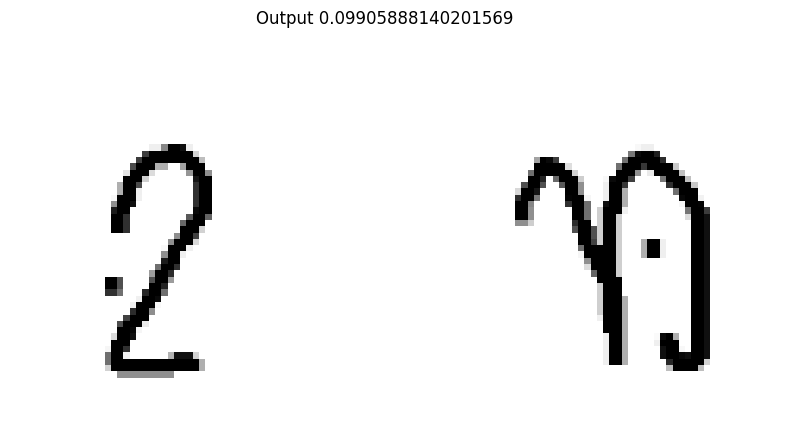

In [28]:
visualize_siamese(siamese_net, train_data, label1=1, label2=3)

In [26]:
siamese_net.save("./siamese_net_2conv")
encoder.save("./siamese_encoder_2conv")
#siamese_net = keras.saving.load_model("./siamese_model")

INFO:tensorflow:Assets written to: ./siamese_net_best2048dense_boost/assets


INFO:tensorflow:Assets written to: ./siamese_net_best2048dense_boost/assets


INFO:tensorflow:Assets written to: ./siamese_encoder_best2048dense_boost/assets


INFO:tensorflow:Assets written to: ./siamese_encoder_best2048dense_boost/assets


In [21]:
def get_mode(l):
        d = {}
        mode = None
        count = 0
        for i in l:
            if i in d:
                d[i] += 1
            else:
                d[i] = 1
            if d[i] > count:
                mode = i
        return mode

def test_siamese(images, labels, num_shots, num_per_char = None, total_num_clas_img = 200):
    total = 0
    matches = 0
    # Splits the data into few shot and support
    os_img, os_label, clas_img, clas_label = separate_fewshot(images, labels, n=num_shots, shuffle_clas=True)
    if num_per_char:
        c_labels = np.unique(clas_label)
        max_clas_size = min(len(c_labels) * num_per_char, len(clas_img))
        n_clas_img = np.zeros((max_clas_size, img_size, img_size, 1))
        n_clas_lbl = np.zeros((max_clas_size))
        for i, l in enumerate(np.unique(clas_label)):
            n_clas_lbl[i * num_per_char:(i+1) * num_per_char] = l
            n_clas_img[i * num_per_char:(i+1) * num_per_char] = clas_img[np.where(clas_label == l)[0]][:num_per_char]
        clas_img, clas_label = n_clas_img, n_clas_lbl
    else:
        clas_img = clas_img[: total_num_clas_img]
        clas_label = clas_label[: total_num_clas_img]

    # Generates all possible pairs of few shot and support
    x, y = [], []
    for i, c_i in enumerate(clas_img):
        x += [c_i.copy() for _ in range(len(os_img))]
        y = [*y, *os_img]
    x = np.array(x)
    y = np.array(y)

    # Passing all the pairs to the network
    t = siamese_net.predict([x, y], verbose=0)
    for i in range(len(clas_img)):
        # Get the argmax for all the supports and check tif the prediction matches
        arr = t[i * len(os_img): (i + 1) * len(os_img)].reshape(-1)
        ind = np.argsort(arr)[-num_shots:]
        ind = get_mode(ind)
        pred = os_label[ind]
        #print(t.shape, ind, pred, clas_label[i])
        matches += np.sum(pred == clas_label[i])
        total += 1
    return (matches, total)

In [22]:
# for alphabet in np.unique(df_test['alphabet']):
    #     ind_alphabet = np.where(df_test['alphabet'] == alphabet)[0]
    #     ind_alphabet = np.where(labels)
    #     labels = test_labels[ind_alphabet]
    #     images = test_images[ind_alphabet]
def test_siamese_random(test_data, test_labels, num_shots, num_classes, num_per_char=10):
    print(num_shots, num_classes)
    matches = 0
    total = 0
    unique_labels = np.unique(test_labels)
    test_times = 100
    for it in range(test_times):
        # Picks num_classes characters at random and limit the dataset to it
        classes = np.random.choice(unique_labels, num_classes, False)
        #print(classes.shape)
        labels = []
        images = []
        for c in classes:
            images += [*test_data[c]]
            labels += [c for _ in range(len(test_data[c]))]
        images = np.array(images)
        labels = np.array(labels)
        temp = test_siamese(images, labels, num_shots, num_per_char)
        matches += temp[0]
        total += temp[1]
        if it % 5 == 0:
            print(it,"Partial accuracy: ", matches/total)

    print("======= NL Autoencoder method: Finished =======")
    
test_data, test_labels = parse_omniglot_dataframe(df_test, img_size=img_size, reshape=False)
test_siamese_random(test_data, test_labels, num_shots=shots, num_classes=num_classes)

1 20
0 Partial accuracy:  0.675
5 Partial accuracy:  0.6141666666666666
10 Partial accuracy:  0.6018181818181818
15 Partial accuracy:  0.595
20 Partial accuracy:  0.6016666666666667
25 Partial accuracy:  0.5980769230769231
30 Partial accuracy:  0.6003225806451613
35 Partial accuracy:  0.6036111111111111
40 Partial accuracy:  0.6041463414634146
45 Partial accuracy:  0.6034782608695652
50 Partial accuracy:  0.6
55 Partial accuracy:  0.6020535714285714
60 Partial accuracy:  0.603688524590164
65 Partial accuracy:  0.6031060606060606
70 Partial accuracy:  0.6051408450704225
75 Partial accuracy:  0.6066447368421053
80 Partial accuracy:  0.6017901234567902
85 Partial accuracy:  0.6016860465116279
90 Partial accuracy:  0.6001098901098901
95 Partial accuracy:  0.60125
100 Partial accuracy:  0.6009405940594059
105 Partial accuracy:  0.6035849056603774
110 Partial accuracy:  0.601081081081081
115 Partial accuracy:  0.6000862068965517
120 Partial accuracy:  0.5997107438016529
125 Partial accuracy:

KeyboardInterrupt: 

In [25]:
def test_siamese_alphabets(test_images, test_labels, num_shots=shots, num_per_char=None, total_num_clas_img=200):
    matches = 0
    total = 0
    
    print("Vectorizing ...")
    for alphabet in np.unique(df_test['alphabet']):
        # Gets just the characters belonging to the current alphabet
        ind_alphabet = np.where(df_test['alphabet'] == alphabet)[0]
        labels = test_labels[ind_alphabet]
        images = test_images[ind_alphabet].reshape(-1, img_size, img_size, 1)
        
        temp = test_siamese(images, labels, num_shots, num_per_char, total_num_clas_img=total_num_clas_img)
        matches += temp[0]
        total += temp[1]
        print("Partial accuracy: ", matches/total)
    print("======= NL Autoencoder method: Finished =======")
    
(test_images, test_labels) = resize_images(df_test['image'], img_size) / 255, df_test['label'].to_numpy()
test_siamese_alphabets(test_images, test_labels, shots, None, 200)

Vectorizing ...
Partial accuracy:  0.695
Partial accuracy:  0.5375
Partial accuracy:  0.49166666666666664
Partial accuracy:  0.49125
Partial accuracy:  0.486
Partial accuracy:  0.4675
Partial accuracy:  0.4585714285714286
Partial accuracy:  0.4225
Partial accuracy:  0.3927777777777778
Partial accuracy:  0.391
Partial accuracy:  0.3781818181818182
Partial accuracy:  0.37333333333333335
Partial accuracy:  0.3707692307692308
Partial accuracy:  0.37357142857142855
Partial accuracy:  0.36433333333333334
Partial accuracy:  0.3546875
Partial accuracy:  0.36058823529411765
Partial accuracy:  0.35555555555555557
Partial accuracy:  0.3505263157894737
Partial accuracy:  0.356
======= NL Autoencoder method: Finished =======


In [24]:
matches = total = 0
print(f"Trying the encoder with {shots} shots")
for alphabet in np.unique(df_test['alphabet']):
    ind_alphabet = np.where(df_test['alphabet'] == alphabet)[0]
    labels = test_labels[ind_alphabet]
    images = test_images[ind_alphabet]
    os_img, os_label, clas_img, clas_label = separate_fewshot(images, labels, n=shots)
    
    os_img = encoder.predict(os_img)
    clas_img = encoder.predict(clas_img)
    
    neigh = KNeighborsClassifier(n_neighbors = shots)
    neigh.fit(os_img, os_label)
    
    pred = neigh.predict(clas_img)
    matches += np.sum(pred == clas_label)
    total += len(clas_label)
print(matches/total)

Trying the encoder with 1 shots
16/16 [==============================] - 0s 1ms/step
0.33407874770385754


In [ ]:
## total = matches = 0
os_img, os_label, clas_img, clas_label = separate_fewshot(test_images, test_labels, n=1)
os_img = encoder.predict(os_img)
clas_img = encoder.predict(clas_img)

#if verbose: print("Learning oneshot ...")
#nn = min(train, 5)
neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(os_img, os_label)

#if verbose: print("Predicting ...")
pred = neigh.predict(clas_img)

matches += np.sum(pred == clas_label)
total += len(clas_label)
print(matches / total)